<img src="imagenes/ia.png" width="250">


# Regresión logística y regularización

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/).

En esta libreta vamos a revisar el algoritmo básco de la regresión logística y los principios básicos de regularización. Si bien es una primera aprximación, espero que se pueda ilustrar en esta libreta tanto el uso básico de la regresión logística como el efecto de la regularización.

Empecemos por inicializar los modulos que vamos a requerir.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

## 1. Función logística, función de error *en muestra* y gradiente de la función de error *en muestra*

La función logística está dada por 

$$
g(z) = \frac{1}{1 + e^{-z}},
$$

la cual es importante que podamos calcular en forma vectorial. Si bien el calculo es de una sola linea, el uso de estas funciones auxiliares facilitan la legibilidad del código.

#### Ejercicio 1: Desarrolla la función logística, la cual se calcule para todos los elementos de un ndarray.

In [3]:
def logistica(z):
    """
    Calcula la función logística para cada elemento de z
    
    @param z: un ndarray
    @return: un ndarray de las mismas dimensiones que z
    """
    # Introduce código aqui (una linea de código)
    g=1/(1+np.exp(-z))
    #---------------------------------------------------
    return g
    #---------------------------------------------------
    
# prueba que efectivamente funciona la función implementada
# si el assert es falso regresa un error de aserción (el testunit de los pobres)
assert (np.abs(logistica(np.array([-1, 0, 1])) - np.array([ 0.26894142, 0.5, 0.73105858]))).sum() < 1e-6


Para entender que hace la función logística, vamos a graficarla (sin clavarnos en los valores exactos) en el intervalo [-5, 5]

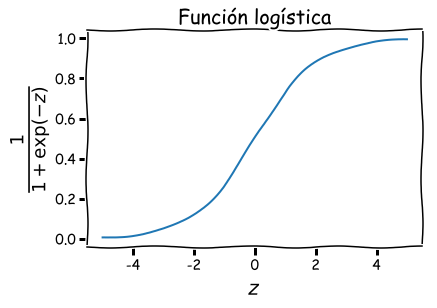

In [4]:
z = np.linspace(-5, 5, 100)
with plt.xkcd():
    plt.plot( z, logistica(z))
    plt.title(u'Función logística', fontsize=20)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\frac{1}{1 + \exp(-z)}$', fontsize=26)


Una vez establecida la función logística, vamos a implementar la función de error en muestra *sin regularizar* que se utiliza típicamente en clasificación binaria, la cual está dada por

$$
E_{in}(y, \hat y ) = -\frac{1}{T} \sum_{i=1}^T \left[ y^{(i)}\log(\hat{y}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{y}^{(i)})\right],
$$

donde 

$$
\hat{y}^{(i)} = g(\omega^T x_e^{(i)}),
$$

las cuales fueron ecuaciones revisadas en clase.

#### Ejercicio 2: Implementa la función de error en muestra para un conjunto de aprendizaje.

In [50]:
def error_muestra(w, x, y):
    """
    Calcula el costo de una w dada para el conjunto dee entrenamiento dado por y y x
    
    @param w: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un flotante con el costo
    
    """ 
    T = x.shape[0]
    
    #------------------------------------------------------------------------
    # Agregua aqui tu código
    yg=logistica(x.dot(w)) #ygorrito
    Ein=np.sum(y*np.log(yg)+(1-y)*np.log(1-yg))
    errorM=(-1/T)*Ein
    return errorM
    #------------------------------------------------------------------------

    
# Otra vez el testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.ones((2,1))

x = np.array([[1, 10],
              [1, -5]])

y1 = np.array([[1],
               [0]])

y2 = np.array([[0],
               [1]])

y3 = np.array([[0],
               [0]])

y4 = np.array([[1],
               [1]])

assert abs(error_muestra(w, x, y1) - 0.01) < 1e-2
assert abs(error_muestra(w, x, y2) - 7.5) < 1e-2
assert abs(error_muestra(w, x, y3) - 5.5) < 1e-2
assert abs(error_muestra(w, x, y4) - 2.0) < 1e-2

De la misma manera, para poder implementar las funciones de aprendizaje, vamos a implementar el gradiente de la función de error respecto a $\omega$, el cuál es (como lo vimos en clase) el siguiente:

$$
\frac{\partial E_{in}}{\partial \omega_j} = -\frac{1}{T} \sum_{i=1}^T \left(y^{(i)} - g(\omega^T x_e^{(i)})\right)x_j^{(i)} 
$$

y a partir de las ecuaciones individuales de puede obtener $\nabla_\omega E_{in}$. Como podemos ver, $\left(y^{(i)} - g(\omega^T x_e^{(i)})\right)$ es un escalar, y es el mismo para todos los atrinutos $x^{(i)}_j$, por lo que el gradiente se puede expresar como

$$
\nabla_\omega E_{in} = -\frac{1}{T} \sum_{i=1}^T \left(y^{(i)} - g(\omega^T x_e^{(i)})\right)x^{(i)}.
$$


Asumimamos entonces que $X = (x^{(1)}, x^{(2)}, \ldots, x^{(T)})^T$ (esto es, el $i$--ésimo renglón representa una situación u objeto, mientras que la $j$--ésima columna representa los valores que toman los diferentes objetos de un atributo), y $Y = (y^{(1)}, y^{(1)}, \ldots, y^{(T)})^T$ (un vector columna con los valores de salida del conjunto $X$). El error en muestra se puede calcular (a partir de la ecuación anterior) como:

$$
\nabla_\omega E_{in} = -\frac{1}{T} X^T \cdot (Y - g(X_e \cdot w)),
$$
donde $X_e$ es la matriz $X$ agregandole al inicio una columna con unos (esto es, el atributo $0$ o valor constante.

#### Ejercicio 3: Implementa (con operaciones matriciales) el calculo del gradiente de la función de pérdida.

In [6]:
def gradiente(w, X, Y):
    """
    Calcula el gradiente de la función de pérdida para clasificación binaria, 
    utilizando una neurona logística, para una theta y conociendo un conjunto de aprendizaje.
    
    @param w: un ndarray de dimensión (n + 1, 1) 
    @param X: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param Y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un ndarray de mismas dimensiones que w
    
    """
    T = X.shape[0]

    #------------------------------------------------------------------------
    # Agregua aqui tu código
    Ein=(-1/T)*(X.T.dot(Y-logistica(X.dot(w))))
    return Ein
    
    #------------------------------------------------------------------------
    
# Otra vez el testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.ones((2, 1))

x = np.array([[1, 10],
              [1, -5]])

y1 = np.array([[1],
               [0]])

y2 = np.array([[0],
               [1]])

y3 = np.array([[0],
               [0]])

y4 = np.array([[1],
               [1]])

assert abs(0.00898475 - gradiente(w, x, y1)[0]) < 1e-4
assert abs(7.45495097 - gradiente(w, x, y2)[1]) < 1e-4 
assert abs(4.95495097 - gradiente(w, x, y3)[1]) < 1e-4 
assert abs(-0.49101525 - gradiente(w, x, y4)[0]) < 1e-4     

## 2. Regresión logística en acción

Ahora vamos a desarrollar las funciones necesarias para realizar el entrenamiento y encontrar la mejor $\omega$ de acuero a la función de costos y un conjunto de datos de aprendizaje.

Para este problema, vamos a utilizar una base de datos sintética proveniente del curso de [Andrew Ng](www.andrewng.org/) que se encuentra en [Coursera](https://www.coursera.org). Supongamos que pertenecemos al departamente de servicios escolares de la UNISON y vamos a modificar el procedimiento de admisión. En lugar de utilizar un solo exámen (EXCOBA) y la información del cardex de la preparatoria, hemos decidido aplicar dos exámenes, uno sicométrico y otro de habilidades estudiantiles. Dichos exámenes se han aplicado el último año aunque no fueron utilizados como criterio. Así, tenemos un historial entre estudiantes aceptados y resultados de los dos exámenes. El objetivo es hacer un método de regresión que nos permita hacer la admisión a la UNISON tomando en cuenta únicamente los dos exámenes y simplificar el proceso. *Recuerda que esto no es verdad, es solo un ejercicio*.

Bien, los datos se encuentran en el archivo `admision.txt` el cual se encuentra en formato `cvs` (osea los valores de las columnas separados por comas. Vamos a leer los datos y graficar la información para entender un poco los datos.

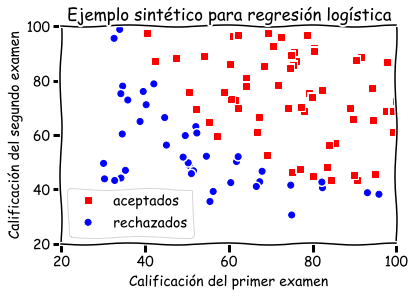

In [7]:
datos = np.loadtxt('datos/admision.txt', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1:] 
x = np.c_[np.ones((x.shape[0], 1)), x]

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)


Vistos los datos un clasificador lineal podría ser una buena solución. Ahora vamos a implementar el método de descenso de gradiente.

Para esto recuerda que el método de aprendizaje por descenso de gradiente se basa en actualizar la fórmulación:

$$
\omega \leftarrow \omega - \alpha \nabla_\omega E_{in} 
$$

#### Ejercicio 4: Implementa el descenso de gradiente para el problema de regresión logística en modo batch.

In [8]:
def descenso(x, y, epsilon, tol=1e-4, max_iter=int(1e4), historial=False):
    """
    Descenso de gradiente por lotes para resolver el problema de regresión logística con un conjunto de aprendizaje

    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos    
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param epsilon: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param tol: Un flotante pequeño como criterio de paro. Por default 1e-4
    @param max_iter: Máximo numero de iteraciones. Por default 1e4
    @param historial: Un booleano para saber si guardamos el historial de la función de pérdida o no
    @return: w, error_hist donde w es ndarray de dimensión (n + 1, 1) y error_hist es un
             ndarray de dimensión (max_iter,) con el valor de la función de error en muestra en cada iteración. 
             Si historial == True, entonces perdida_hist = None.
    """
    T, n = x.shape[0], x.shape[1] - 1
    
    w = np.zeros((n + 1, 1))
    error_hist = np.zeros(max_iter) if historial else None
    
    for iter in range(max_iter):
        #--------------------------------------------------------------
        # Agregar aqui tu código
        # Recuerda utilizar las funciones que ya has desarrollado
        #--------------------------------------------------------------
        w = w + ((1/T)*epsilon)*(-gradiente(w,x,y))
                 
        if historial:
            error_hist[iter] = error_muestra(w,x,y)

    return w, error_hist


Para probar la función de aprendizaje, vamos a aplicarla a nuestro problema de admisión. Primero tenemos que hacer una exploración para encontrar el mejor valor de $\epsilon$. Así que utilizamos el código de abajo para ajustar $\epsilon$ visualmente. 

Busca el valor mas grande de $\epsilon$ tal que el método no se vuelva inestable, te recomiendo que utilices la estratégia de probar con `1e-4`, `5e-4`, `1e-3`, `5e-3`, `1e-2`, `5e-2`, ...

Text(0.5,0,'error')

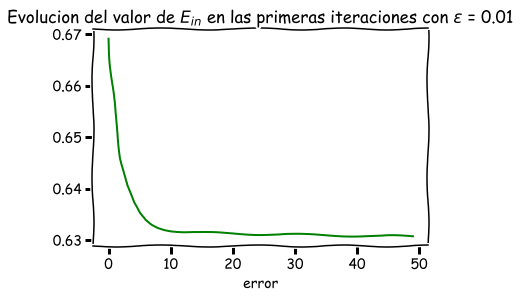

In [9]:
epsilon = 1e-2
mi = 50
_, error_hist = descenso(x, y, epsilon, tol=1e-4, max_iter=mi, historial=True)

plt.plot(np.arange(mi), error_hist, 'green')
plt.title(r'Evolucion del valor de $E_{in}$ en las primeras iteraciones con $\epsilon$ = ' + str(epsilon))
plt.xlabel('error')


Una vez encontrado el mejor $\epsilon$, entonces podemos calcular $\omega$ (esto va a tardar algo), recuerda que el costo final debe de ser lo más cercano a 0 posible, así que agrega cuantas iteraciones sean necesarias: 

In [10]:
w, _ = descenso(x, y, epsilon, max_iter = int(1e9))
print("Los pesos obtenidos son: \n{}".format(w))
print("El valor final de la función de error en muestra es: {}".format(error_muestra(w, x, y))) 

KeyboardInterrupt: 

Este método nos devuelve $\omega$, pero esto no es suficiente para decir que tenemos un clasificador, ya que un método de clasificación se compone de dos métodos, uno para **aprender** y otro para **predecir**. Recuerda que para realizar la predicción tenemos que decidir cual es el umbral por el cual consideramos que la clase estimada es 1 (la clase distinguida).

#### Ejercicio 5: Desarrolla una función de predicción.

In [45]:
def predictor(w, x):
    """
    Predice los valores de y_hat (que solo pueden ser 0 o 1), utilizando el criterio MAP.
    
    @param w: un ndarray de dimensión (n + 1, 1)
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos

    @return: y_hat un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    """
    #-------------------------------------------------------------------------------------
    # Agrega aqui tu código sin utilizar la función logística
    y_hat = np.where(x > 0.5, 1,0)
    return y_hat
    #--------------------------------------------------------------------------------------

    

¿Que tan bueno es este clasificador? ¿Es que implementamos bien el método?

Vamos a contestar esto por partes. Primero, vamos a graficar los mismos datos pero vamos a agregar la superficie de separación, la cual en este caso sabemos que es una linea recta. Como sabemos el criterio para decidir si un punto pertenece a la clase 1 o cero es si el valor de $\omega^T x_e^{(i)} \ge 0$, por lo que la frontera entre la región donde se escoge una clase de otra se encuentra en:

$$
0 = \omega_0 + \omega_1 x_1  + \omega_2 x_2,
$$

y despejando:

$$
x_2 = -\frac{\omega_0}{\omega_2} -\frac{\omega_1}{\omega_2}x_1
$$

son los pares $(x_1, x_2)$ de valores en la forntera. Al ser estos (en este caso) una linea recta solo necesitamos dos para graficar la superficie de separación. 


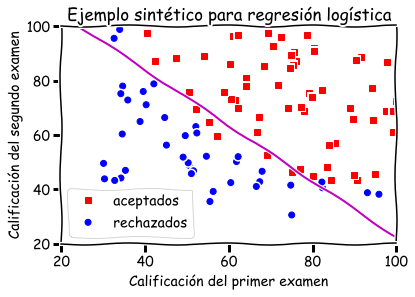

In [46]:
x1_frontera = np.array([20, 100]) #Los valores mínimo y máximo que tenemos en la gráfica de puntos
x2_frontera = -(w[0] / w[2]) - (w[1] / w[2]) * x1_frontera

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.plot(x1_frontera, x2_frontera, 'm')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)



Y para que tengas una idea de lo que debería de salir, anexo una figura obtenida con el código que yo hice:

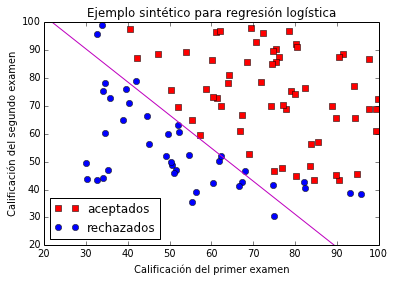

In [69]:
Image(filename='imagenes/ejemplo_logistica_1.png')

## 3. Generando atributos polinomiales

Como podemos ver en las gráficas de arriba, parece ser que la regresión logística aceptaría a algunos estudiantes rechazados y rechazaría a algunos que si fueron en realidad aceptados. En todo método de clasificación hay un grado de error, y eso es parte del poder de generalización de los métodos. 

Sin embargo, una simple inspección visual muestra que, posiblemente, la regresión lineal no es la mejor solución, ya que la frontera entre las dos clases parece ser más bien una curva.

¿Que tal si probamos con un clasificador cuadrático? Un clasificador cuadrático no es más que la regresión logística pero a la que se le agregan todos los atributos que sean una combinación de dos de los atributos. 

Por ejemplo, si un objeto $x_e = (1, x_1, x_2, x_3)^T$ se aumenta con todas sus componentes cuadráticas, entonces tenemos los atributos

$$
\phi_2(x_e) = (1, x_1, x_2, x_3, x_1 x_2, x_1 x_3, x_2 x_3, x_1^2, x_2^2, x_3^2)^T.
$$ 

De la misma manera se pueden obtener clasificadores de orden tres, cuatro, cinco, etc. En general a estos clasificadores se les conoce como **clasificadores polinomiales**. Ahora, para entender bien la idea, vamos a resolver el problema anterior con un clasificador de orden 2. Sin embargo, si luego se quiere hacer el reconocimiento de otros objetos, o cambiar el orden del polinomio, pues se requeriría de reclcular cada vez la expansión polinomial a mano. Esto no es una muy buena práctica, así que vamos a generalizar la obtención de atributos polinomiales con la función `map_poly`, la cual la vamos a desarrollar a continuación.

In [26]:
from itertools import combinations_with_replacement

def map_poly(grad, x):
    """
    Encuentra las características polinomiales hasta el grado grad de la matriz de datos x, 
    asumiendo que x[:, 0] es la expansión de orden 0 (un vector de puros unos) y x[1:n, 0]
    es la expansión de orden 1 (los valores de cada atributo)
    
    @param grad: un entero positivo con el grado de expansión
    @param x: un ndarray de dimension (T, n + 1) donde n es el número de atributos
    
    @return: un ndarray de dimensión (T, n_phi + 1) donde
             n_phi = \sum_{i = 1}^grad fact(i + n - 1)/(fact(i) * fact(n - 1))
    """
    
    if int(grad) < 2:
        raise ValueError('grad debe de ser mayor a 1')
    
    T, n = x.shape[0], x.shape[1] - 1 
    atrib = x[:,1:]
    x_phi = x.copy()
    for i in range(2, int(grad) + 1):
        for comb in combinations_with_replacement(range(n), i):
            x_phi = np.c_[x_phi, np.prod(atrib[:, comb], axis=1)]
    return x_phi        


#### Ejercicio 6: Realiza el clasificador polinomial de orden 2 de los datos de los exámenes

In [15]:
# Vamos a dar una guia paso a paso de lo que hay que hacer

# Encuentra phi_x (x son la expansión polinomial de segundo orden, utiliza la función map_poly
phi_x = map_poly(2,x)# grado 2 de expansion

# Genera la theta inicial
#theta_phi0 = # <--- Completa el código ----

Text(0,0.5,'error')

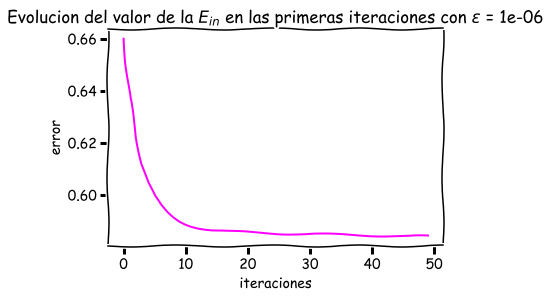

In [16]:
# Ahora hay que hacer varias pruebas para seleccionar el mejor valor de epsilon
epsilon = 1e-6
mi = 50
_, error_hist = descenso(phi_x, y, epsilon, tol=1e-4, max_iter=mi, historial=True)

plt.plot(np.arange(mi), error_hist, 'magenta')
plt.title(r'Evolucion del valor de la $E_{in}$ en las primeras iteraciones con $\epsilon$ = ' + str(epsilon))
plt.xlabel('iteraciones')
plt.ylabel('error')

In [20]:
# Por último se hace el aprendizaje con el epsilon seleccionado
epsilon = 1e-6
w_2, _ = descenso(phi_x, y, epsilon, max_iter = int(1e8))
print("Los pesos obtenidos son: \n{}".format(w_2))
print("El valor final de la función de error en muestra es: {}".format(error_muestra(w_2, phi_x, y))) 


Los pesos obtenidos son: 
[[ -1.06503908e-02]
 [ -2.99174844e-01]
 [ -3.27685693e-01]
 [  2.69278982e-04]
 [  1.00371960e-02]
 [  5.97216267e-04]]
El valor final de la función de error en muestra es: 0.08443451226961166


El reusltado debe de ser algo similar a:

$$
\theta_\phi = (15.87, -428.13, -110.51, 1.63, -0.8889, 8.6)^T
$$

Y esto lo tenemos que graficar. Pero graficar la separación de datos en una proyección en las primeras dos dimensiones, no es tan sencillo como 
lo hicimos con una separación lineal, así que vamos atener que generar un `contour`, y sobre este graficar los datos. Para esto vamos a desarrollar una función (esta la hago yo porque es un poco dificil y no da luz sobre los temas escenciales).

In [28]:
def plot_separacion2D(x, y, grado, theta_phi):
    """
    Grafíca las primeras dos dimensiones (posiciones 1 y 2) de datos en dos dimensiones 
    extendidos con un clasificador polinomial así como la separación dada por theta_phi
    
    """
    if grado < 2:
        raise ValueError('Esta función es para graficar separaciones con polinomios mayores a 1')
    
    x1_min, x1_max = np.min(x[:,1]), np.max(x[:,1])
    x2_min, x2_max = np.min(x[:,2]), np.max(x[:,2])
    delta1, delta2 = (x1_max - x1_min) * 0.1, (x2_max - x2_min) * 0.1

    spanX1 = np.linspace(x1_min - delta1, x1_max + delta1, 200)
    spanX2 = np.linspace(x2_min - delta2, x2_max + delta2, 200)
    X1, X2 = np.meshgrid(spanX1, spanX2)
        
    Z = map_poly(grado, np.c_[np.ones((X1.size, 1)), X1.ravel(), X2.ravel()]).dot(theta_phi)
    Z = Z.reshape(X1.shape[0], X1.shape[1])
    
    plt.contour(X1, X2, Z, [0], linewidths=0.5, colors='k')
    plt.contourf(X1, X2, Z, 1, cmap=plt.cm.gray)
    plt.plot(x[y.ravel() > 0.5, 1], x[y.ravel() > 0.5, 2], 'sr', label='aceptados')
    plt.plot(x[y.ravel() < 0.5, 1], x[y.ravel() < 0.5, 2], 'oy', label='rechazados')
    plt.axis([spanX1[0], spanX1[-1], spanX2[0], spanX2[-1]])
    

Y ahora vamos a probar la función plot_separacion2D con los datos de entrenamiento. El comando tarda, ya que estamos haciendo un grid de 200$\times$200, y realizando evaluaciones individuales.

Text(0,0.5,'Calificación del segundo examen')

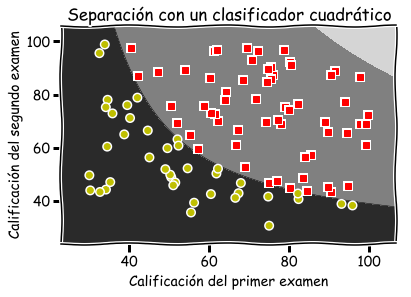

In [22]:
plot_separacion2D(x, y, 2, w_2)
plt.title(u"Separación con un clasificador cuadrático")
plt.xlabel(u"Calificación del primer examen")
plt.ylabel(u"Calificación del segundo examen")

Muy bien, un clasificador polinomial de orden 2 clasifica perfectamente los datos de aprendizaje, y además parece sufucuentemente simple para ser la mejor opción para hacer la predicción.

Tomemos ahora una base de datos que si bien es sintética es representativa de una familia de problemas a resolver. Supongamos que estámos opimizando la fase de pruebas dentro de la linea de producción de la empresa *Microprocesadores del Noroeste S.A. de C.V.*. La idea es reducir el banco de pruebas de cada nuevo microprocesador fabricado y en lugar de hacer 50 pruebas, redcirlas a 2. En el conjunto de datos tenemos los valores que sacó cada componente en las dos pruebas seleccionadas, y la decisión que se tomo con cada dispositivo (esta desición se tomo con el banco de 50 reglas). Los datos los podemos visualizar a continuación.

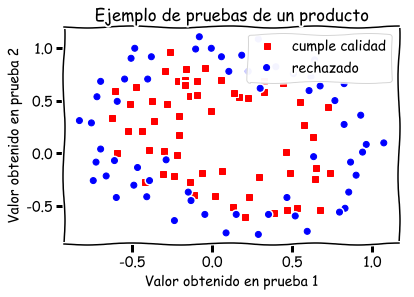

In [65]:
datos = np.loadtxt('datos/prod_test.txt', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1:] 
x = np.c_[np.ones((x.shape[0], 1)), x]

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='cumple calidad') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazado')
plt.title(u'Ejemplo de pruebas de un producto')
plt.xlabel(u'Valor obtenido en prueba 1')
plt.ylabel(u'Valor obtenido en prueba 2')
#plt.axis([20, 100, 20, 100])
plt.legend(loc=1)

Cláramente este problema no se puede solucionar con un clasificador lineal (1 orden), por lo que hay que probar otros tipos de clasificadores.

#### Ejercicio 7: Prueba hacer regresión polinomial para polinomios de orden 2, 4, 6 y 8, y grafica los resultados en una figura cada uno. Recuerda que este ejercicio puede tomar bastante tiempo de cómputo dependiendo tanto del método de optimización seleccionado como de la graficacion, al final agrega una celda de texto donde comentes los resultados .

Y para dar una guía de lo que se espera, anexo las imágenes de las gráficas para el polinomio de orden 2 y para el polinomio de orden 8. 


![](imagenes/ejemplo_logistica_2.png)         ![](imagenes/ejemplo_logistica_3.png)

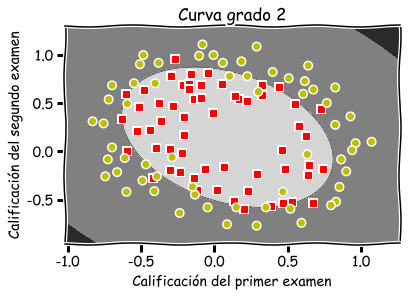

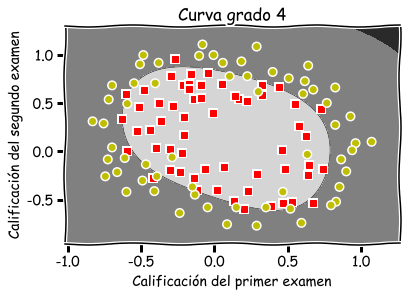

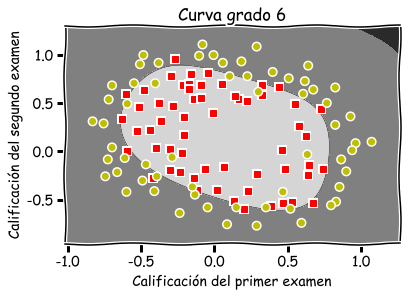

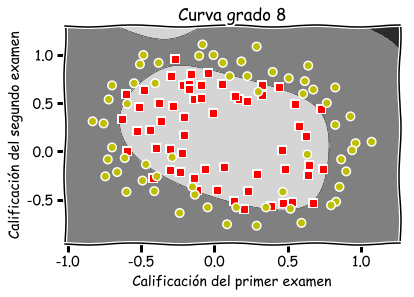

In [46]:
# Vamos a hacer una pequeña funcion para hacer todo de forma más fácil

def aprende_polinomial(x, y, grado):
    """
    Aprende un clasificador polinomial para el conjunto de aprendizaje dado por x (ya extendida) y y
    
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: theta_phi un ndarray con los valores necesarios para theta extendida en el espacio de x_phi.
    
    """
    epsilon = 1000
    mi = 700
    xi = map_poly(grado,x)
    theta_phi,_=descenso(xi, y, epsilon, tol=1e-4, max_iter=mi, historial=True)
    return theta_phi
    
# Ahora vamos a utilizar esto para graficar las diferentes curvas
for grado in [2, 4, 6, 8]:
    figure = plt.figure()
    w_2 = aprende_polinomial(x,y,grado)
    plot_separacion2D(x, y, grado, w_2)
    plt.title(u"Curva grado {}".format(grado))
    plt.xlabel(u"Calificación del primer examen")
    plt.ylabel(u"Calificación del segundo examen")
    plt.show()
    
    

## 4. Regularización

Como podemos ver del ejercicio anterior, es dificil determinar el grado del polinomio, y en algunos casos es demasiado general (subaprendizaje) y en otros demasiado específico (sobreaprendizaje). ¿Que podría ser la solución?, bueno, una solución posible es utilizar un polinomio de alto grado (o relativamente alto), y utilizar la **regularización** para controlar la generalización del algoritmo, a través de una variable $\lambda$.

Recordemos, la función de costos de la regresión logística con regularización es:

$$
J(\omega) = -\frac{1}{T} \sum_{i=1}^T \left[ y^{(i)}\log(\hat{y}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{y}^{(i)})\right] + \frac{\lambda}{2T}\sum_{j = 1}^n \omega_j^2,
$$

que es básicamente la misma que la función de $E_{in}$, pero además se le suma el una constante por el promedio del cuadrado de los parámetros (a excepción de $\omega_0$). Notese que en este caso lo que vamos a optimizar es una *función de costo* y no el error *en muestra*. El costo se compone de una parte que intenta hacer $E_{in}$ tienda a 0, y otra parte que intenta que el error *en muestra* se parezca (PAC) al error *fuera de muestra*.

#### Ejercicio 8: Desarrolla sin utilizar ciclos `for` la forma de calcular el costo para el problema de regresión logística regularizada 

In [66]:
def costo_regularizado(theta, x, y, lammbda):
    """
    Función de costo con regularización para la regresión logística para los parámetros theta con
    el conjunto de entrenamiento dado por x y y, y la constante de regularización lambda.
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param lammbda: un escalar mayor o igual a 0 (o 0.0)
    
    @return: un flotante con el costo
    
    """ 
    #---------------------------------------------------------------------------------------
    # Inserta aquí tu código
    T = x.shape[0]
    yg=logistica(x.dot(theta)) #ygorrito
    p1=-(np.sum(y*np.log(yg)+(1-y)*np.log(1-yg))/T) 
    p2=((lammbda/(2*T))*(np.sum(np.power(theta,2))))
    return p1+p2
    
    #----------------------------------------------------------------------------------------
    
# Y para probarlo vamos a hacer un unittest de los pobres, utilizando la base de datos 
# que tenemos actualmente cargada (prod_test.txt) 

phi_x = map_poly(6, x)
omega_prueba = np.zeros((phi_x.shape[1], 1))

assert abs(costo_regularizado(omega_prueba, phi_x, y, 1) - 0.693) <= 0.001

Y, por supuesto, para poder utilizar un algoritmo eficiente de optimización, debemos ser capaces de calcular el gradiente de la función.

#### Ejercicio 9: Desarrolla, aprovechando al máximo de las ventajas de ndarrays, la función del gradiente con regularización.

In [67]:
def gradiente_regularizado(theta, x, y, lammbda):
    """
    Calcula el gradiente del costo de la regresión logística, para una theta, conociendo un conjunto de aprendizaje
    y con regularización.
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param lammbda: un escalar mayor o igual a 0 (o 0.0)
    
    @return: un ndarray de mismas dimensiones que theta
    
    """
    T = x.shape[0]
    theta_copy = theta.copy()
    grad = -x.T.dot(y-logistica(x.dot(theta)))/T
    return grad + lammbda*theta_copy/T 
    #------------------------------------------------------------------------
    # Agregua aqui tu código
    #------------------------------------------------------------------------
    
     
# Y para probar vamos a hacer esto:
phi_x = map_poly(6, x)
theta_prueba = np.zeros((phi_x.shape[1], 1))
grad_theta_prueba = gradiente_regularizado(theta_prueba, phi_x, y, 1)

assert abs(grad_theta_prueba[0] - 8.47e-3) < 1e-5
assert abs(grad_theta_prueba[5] - 3.76e-2) < 1e-4
assert abs(grad_theta_prueba[-1] - 3.88e-2) < 1e-4

Y ya por último queda probar la regresión logística con regularización, por lo que vamos a generar 3 superficies: una *aceptable*, otra con sobreaprendizaje y la última con subaprendizaje.

#### Ejercicio 10: Desarrolla las funciones y scriprs necesarios para realizar la regresión logística con un polinomio de grado 8 y con regularización. Grafica la superficie de separación para $\lambda$ igual a 1 (*aceptable*), 0 (*sobreaprendizaje*), 200 (*subaprendizaje*) .

Y de nuevo, como forma de verificar si lo están haciendo bien o no, incluyo dos de las tres figuras que deben obtener, tal como yo las obtuve.

![](imagenes/ejemplo_logistica_4.png)

![](imagenes/ejemplo_logistica_5.png)


In [ ]:
# Aqui pues ya no agrego nada de código para guiar el trabajo ya que es 
# bastante parecido a lo que se hizo en la sección anterior.



